In [1]:
import os
os.chdir('..')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.data_loader import load_stock_data, split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.partial_cointegration import PartialCointegrationModel
from strategies.SAPT import PartialCointegrationTraderSAPT
from utils.visualization import plot_partial_cointegration_trade
from models.structuralbreaksdetector import generate_structural_break_dataset, StructuralBreakDetector
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [3]:
data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)

Chargement des données à partir de data\jse_stocks.csv...
(6488, 29)


In [4]:
try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Informations sectorielles chargées pour 29 actions


In [5]:
# Étapes précédentes
train_data, test_data = split_data(prices, train_ratio=0.7)
print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data, significance_level=0.05)
print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées sur toute la période disponible")
cointegrated_pairs.sort(key=lambda x: x[2])


Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 16 paires co-intégrées sur toute la période disponible


In [6]:
# Génération des données pour le modèle de détection
dataset = generate_structural_break_dataset(
    train_data, cointegrated_pairs, input_length=90, future_window=90, adf_threshold=0.2
)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)     

# Instancier modèle
model = StructuralBreakDetector(input_length=90, wavelet_widths=np.arange(1, 11))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Entraînement
n_epochs = 5
model.train()
for epoch in range(n_epochs):
    total_loss = 0
    for spread, y_price, x_price, label in train_loader:
        optimizer.zero_grad()
        output = model(spread, y_price, x_price)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (output > 0.5).float()
        acc = (pred == label).float().mean()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Acc: {acc:.2%}")

Taux de cibles instables pour IMP.JO et AEG.JO: 74.71%
Taux de cibles instables pour AMS.JO et MUR.JO: 73.49%
Taux de cibles instables pour FSR.JO et DSY.JO: 64.46%
Taux de cibles instables pour AMS.JO et AEG.JO: 74.13%
Taux de cibles instables pour SOL.JO et MTN.JO: 75.17%
Taux de cibles instables pour IMP.JO et MUR.JO: 75.17%
Taux de cibles instables pour MRP.JO et APN.JO: 77.00%
Taux de cibles instables pour NTC.JO et APN.JO: 76.82%
Taux de cibles instables pour AGL.JO et AEG.JO: 79.84%
Taux de cibles instables pour SBK.JO et PIK.JO: 65.08%
Taux de cibles instables pour REM.JO et APN.JO: 69.50%
Taux de cibles instables pour SOL.JO et ABG.JO: 74.98%
Taux de cibles instables pour REM.JO et MRP.JO: 65.44%
Taux de cibles instables pour FSR.JO et BTI.JO: 67.23%
Taux de cibles instables pour MRP.JO et NTC.JO: 74.27%
Taux de cibles instables pour PIK.JO et CLH.JO: 67.35%


c:\Users\emmae\OneDrive\Documents\M2\S2\Kalman-Filtering-Applied-to-Investment-Portfolio-Management\models\structuralbreaksdetector.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X_spread = torch.tensor(X_spread, dtype=torch.float32)


Epoch 1, Loss: 651.7410, Acc: 81.25%
Epoch 2, Loss: 647.9744, Acc: 81.25%
Epoch 3, Loss: 647.4078, Acc: 81.25%
Epoch 4, Loss: 646.5153, Acc: 62.50%
Epoch 5, Loss: 645.6060, Acc: 75.00%


In [7]:
test_dataset = generate_structural_break_dataset(
    test_data, cointegrated_pairs, input_length=90, future_window=90, adf_threshold=0.2
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for spread, y_price, x_price, label in test_loader:
        output = model(spread, y_price, x_price)
        all_preds.append(output.cpu())
        all_labels.append(label.cpu())

# Concaténer les résultats
preds = torch.cat(all_preds).numpy().flatten()
labels = torch.cat(all_labels).numpy().flatten()

binary_preds = (preds > 0.5).astype(int)

print(f"Accuracy       : {accuracy_score(labels, binary_preds):.2%}")
print(f"Precision      : {precision_score(labels, binary_preds):.2%}")
print(f"Recall         : {recall_score(labels, binary_preds):.2%}")
print(f"ROC AUC Score  : {roc_auc_score(labels, preds):.4f}")


Taux de cibles instables pour IMP.JO et AEG.JO: 81.78%
Taux de cibles instables pour AMS.JO et MUR.JO: 82.46%
Taux de cibles instables pour FSR.JO et DSY.JO: 75.89%
Taux de cibles instables pour AMS.JO et AEG.JO: 74.99%
Taux de cibles instables pour SOL.JO et MTN.JO: 82.97%
Taux de cibles instables pour IMP.JO et MUR.JO: 84.72%
Taux de cibles instables pour MRP.JO et APN.JO: 76.74%
Taux de cibles instables pour NTC.JO et APN.JO: 70.12%
Taux de cibles instables pour AGL.JO et AEG.JO: 73.80%
Taux de cibles instables pour SBK.JO et PIK.JO: 78.95%
Taux de cibles instables pour REM.JO et APN.JO: 68.19%
Taux de cibles instables pour SOL.JO et ABG.JO: 83.93%
Taux de cibles instables pour REM.JO et MRP.JO: 74.93%
Taux de cibles instables pour FSR.JO et BTI.JO: 75.72%
Taux de cibles instables pour MRP.JO et NTC.JO: 78.32%
Taux de cibles instables pour PIK.JO et CLH.JO: 71.65%
Accuracy       : 77.20%
Precision      : 77.20%
Recall         : 100.00%
ROC AUC Score  : 0.5167



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006223)
  Secteurs: AMS.JO (Resources), MUR.JO (Construction)
  Même secteur: Non

Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007155)
  Secteurs: FSR.JO (Financials), DSY.JO (Financials)
  Même secteur: Oui

Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011128)
  Secteurs: AMS.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Secteurs: SOL.JO (Resources), MTN.JO (Technology)
  Même secteur: Non


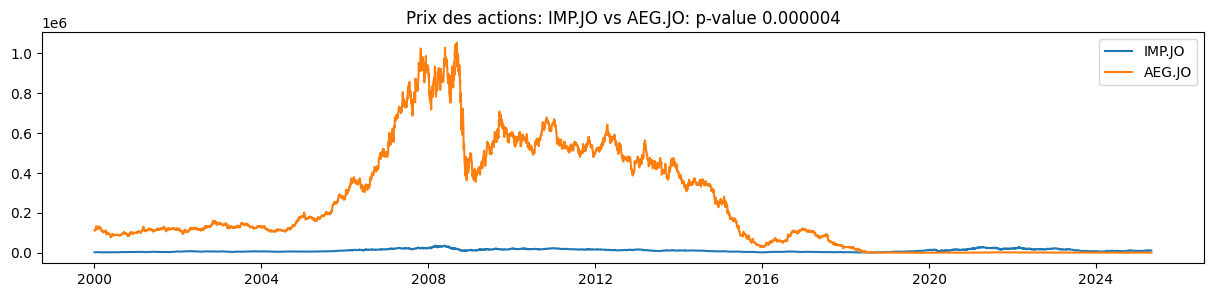

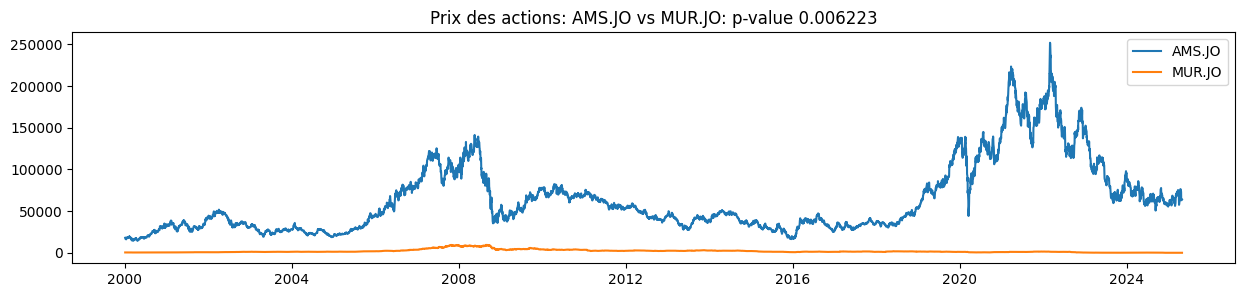

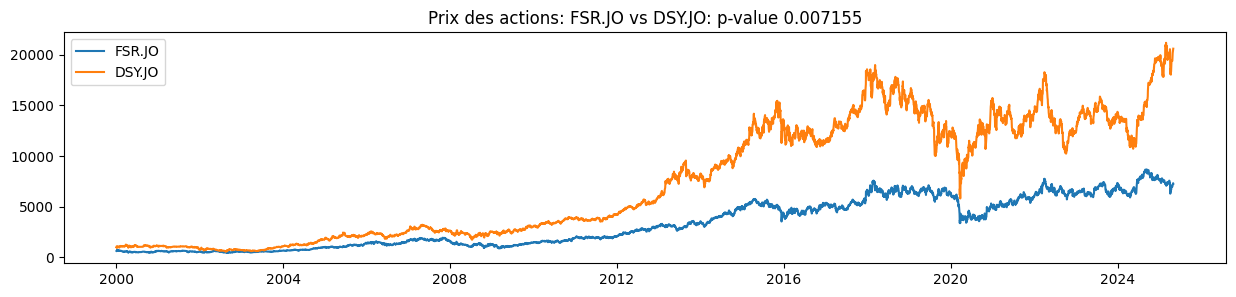

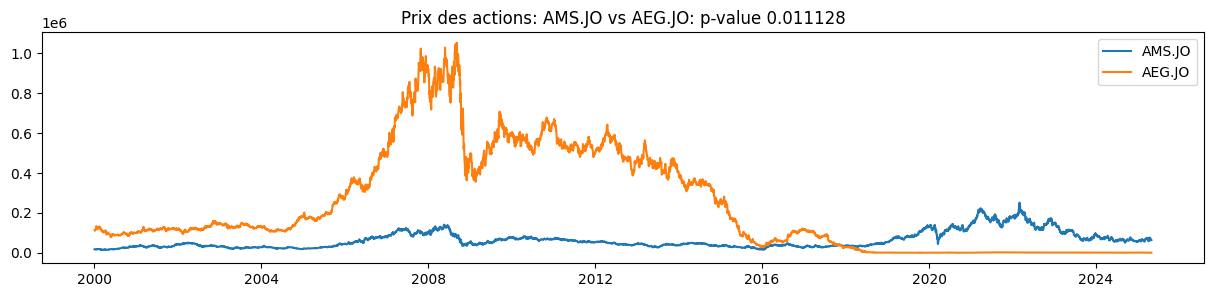

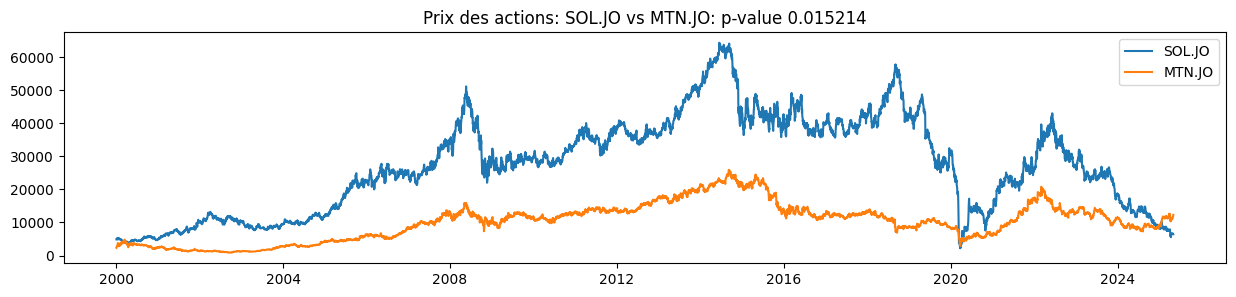

In [8]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(prices[ticker1], label=ticker1)
    plt.plot(prices[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 2705.3447, Sharpe: 1.6851, Trades: 8

Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006223)
  Secteurs: AMS.JO (Resources), MUR.JO (Construction)
  Même secteur: Non
    Aucun trade réalisé.

Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007155)
  Secteurs: FSR.JO (Financials), DSY.JO (Financials)
  Même secteur: Oui
  Performance: Rendement total: 360.8245, Sharpe: 0.9945, Trades: 6

Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011128)
  Secteurs: AMS.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: -10964.0071, Sharpe: -0.8137, Trades: 4

Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Secteurs: SOL.JO (Resources), MTN.JO (Technology)
  Même secteur: Non
  Performance: Rendement total: 226.9918, Sharpe: 0.0564, Trades: 12


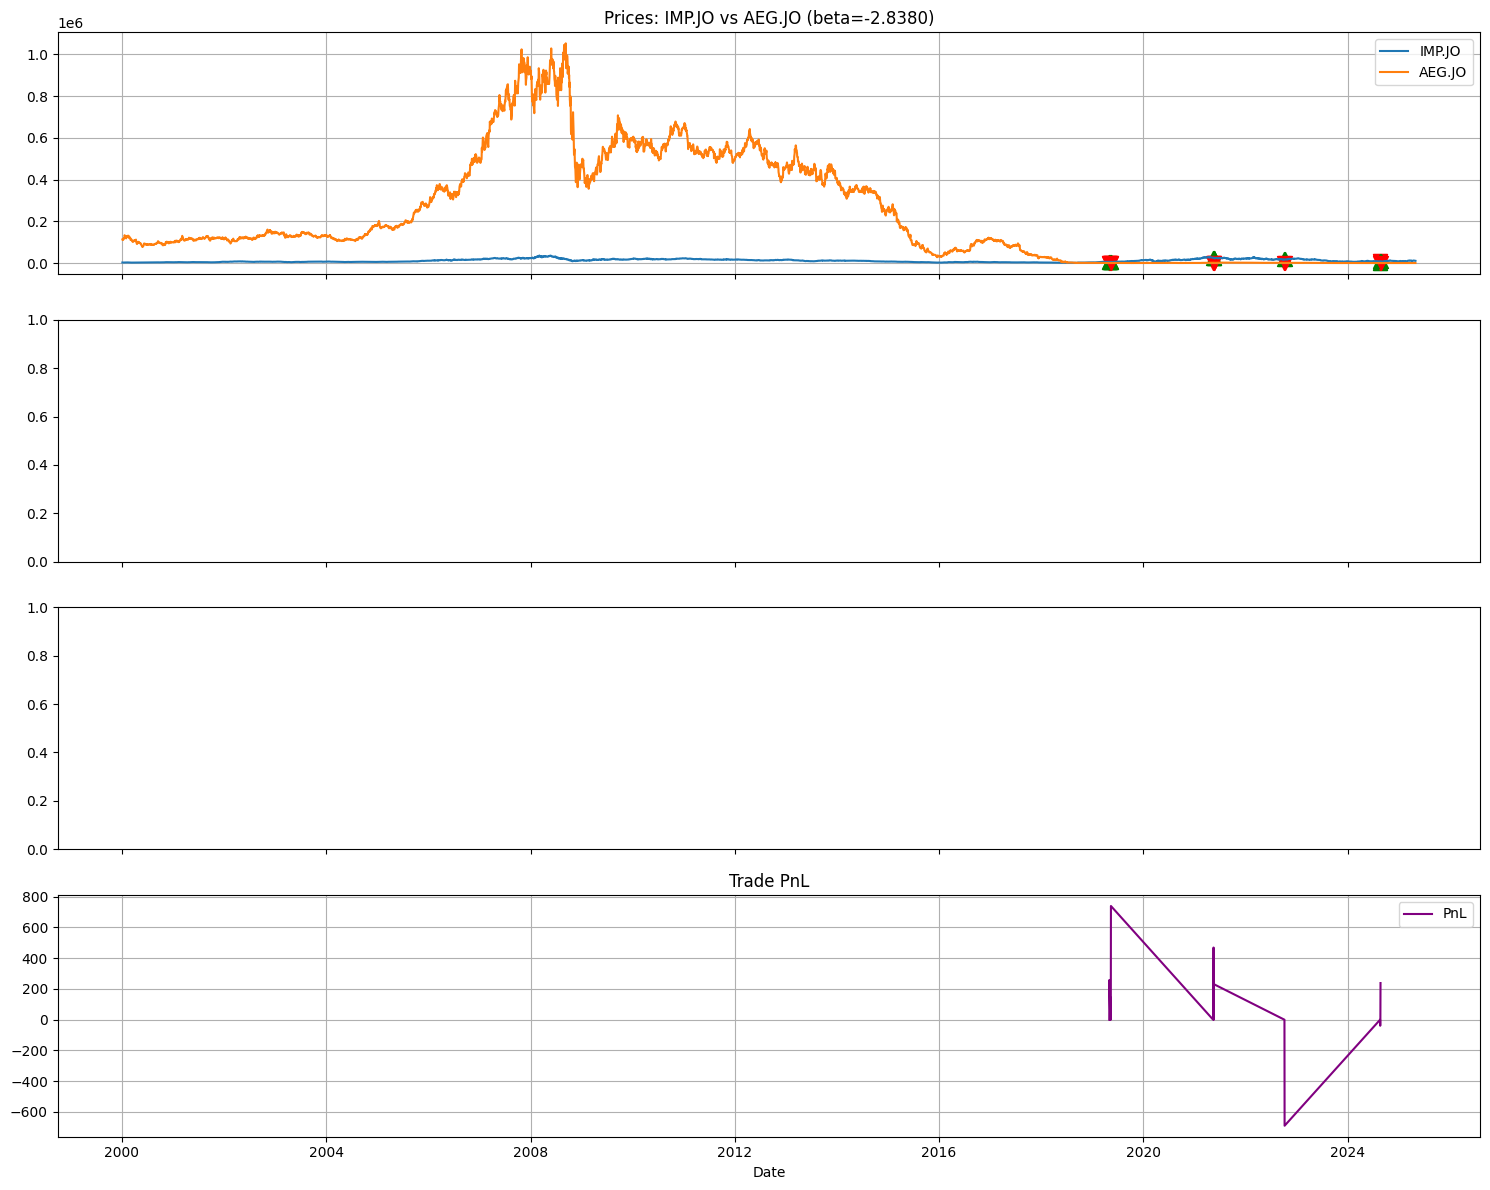

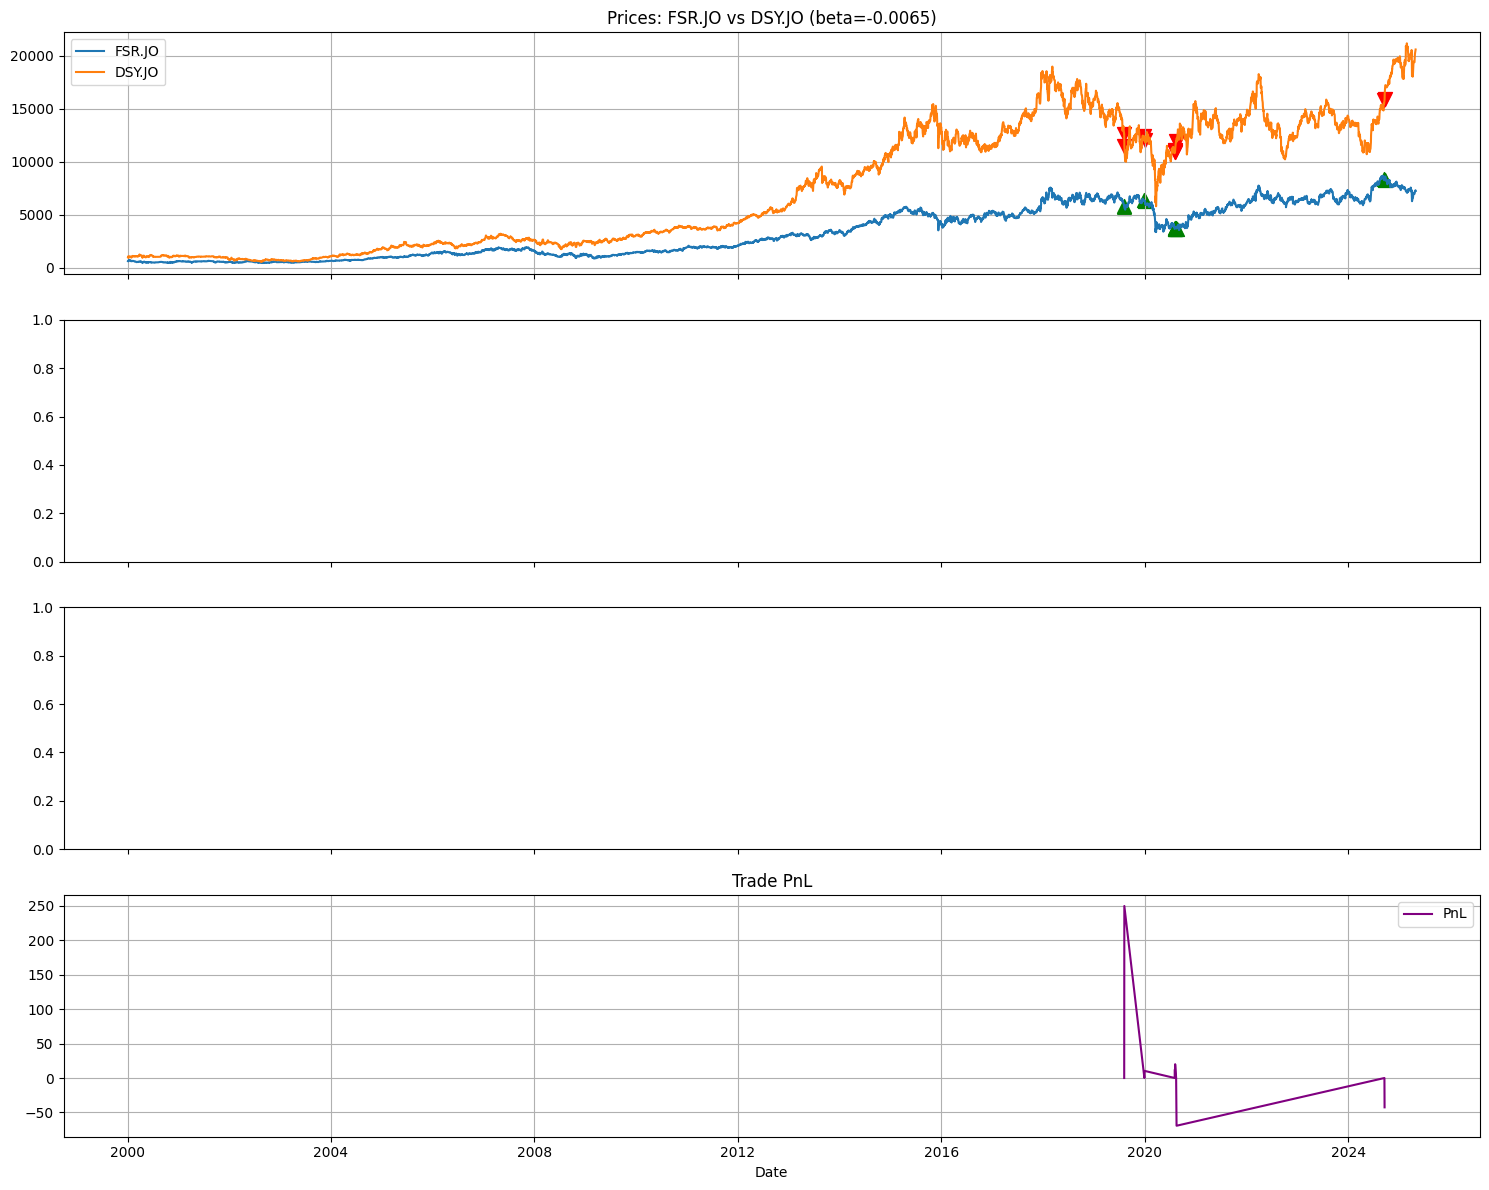

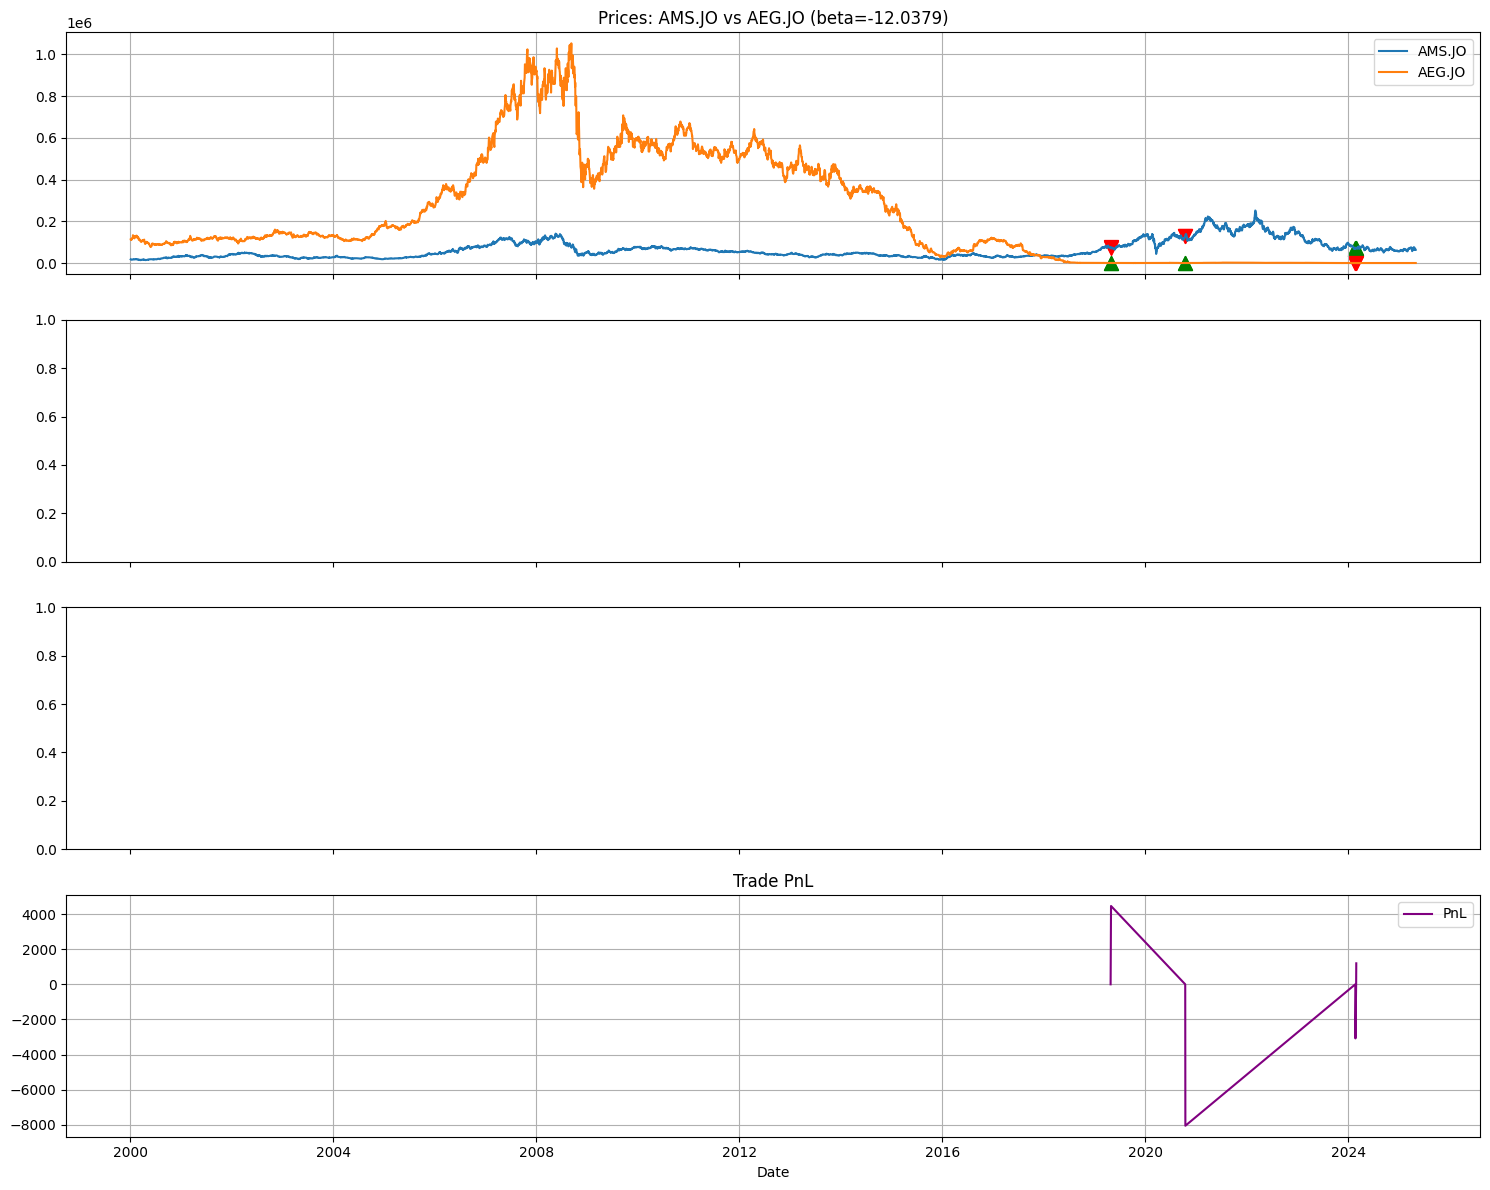

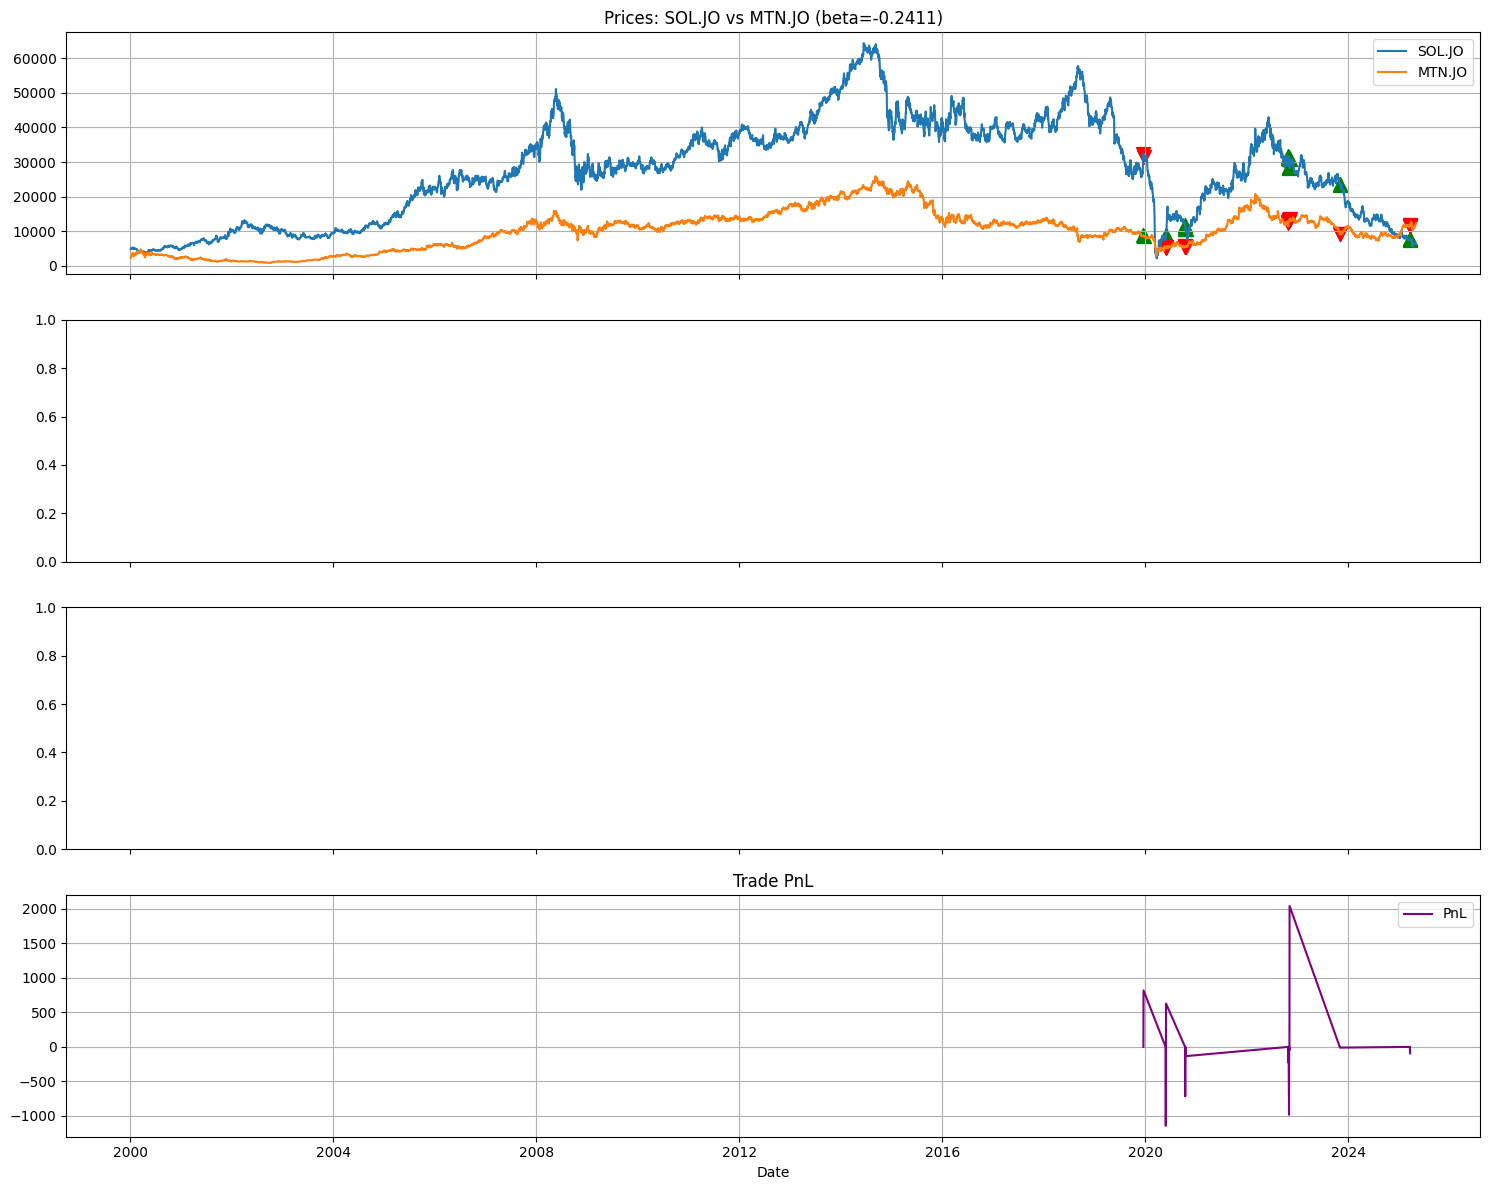

In [15]:
model.eval()

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    co_model = PartialCointegrationModel(significance_level=0.05)

    trader = PartialCointegrationTraderSAPT(
        co_model,
        entry_threshold=1.25,  # Valeur optimale selon le document
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=90,
        kalman_gain=0.7  # Valeur optimale selon le document
    )

    trades = trader.run_backtest(
    test_data[ticker1],
    test_data[ticker2],
    structural_break_model=model,
    input_length=90
)


    if trades.empty:
        print("    Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trader.trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values
    sharpe = (
        np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
        if len(pnl_values) >= 2 and np.std(pnl_values) > 0
        else 0
    )

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": co_model.beta,
            "Intercept": co_model.intercept,
            "Rho": co_model.rho,  # Spécifique à la cointégration partielle
            "Kalman_Gain": co_model.kalman_gain,  # Spécifique à la cointégration partielle
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    
    plot_partial_cointegration_trade(
        prices=prices,
        ticker1=ticker1,
        ticker2=ticker2,
        trades=trades,
        beta=co_model.beta,
        entry_threshold=1.25  # Valeur optimale pour la cointégration partielle
    )


In [16]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    co_model = PartialCointegrationModel(significance_level=0.05)

    trader = PartialCointegrationTraderSAPT(
        co_model,
        entry_threshold=1.25,  # Valeur optimale selon le document
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=90,
        kalman_gain=0.7  # Valeur optimale selon le document
    )

    trades = trader.run_backtest(
    test_data[ticker1],
    test_data[ticker2],
    structural_break_model=model,
    input_length=90
)
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")


    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": co_model.beta,
            "Intercept": co_model.intercept,
            "Rho": co_model.rho,  # Spécifique à la cointégration partielle
            "Kalman_Gain": co_model.kalman_gain,  # Spécifique à la cointégration partielle
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )


Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Performance: Rendement total: 2705.3447, Sharpe: 1.6851, Trades: 24

Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006223)
  ⚠️  Aucun trade réalisé.

Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007155)
  Performance: Rendement total: 360.8245, Sharpe: 0.9945, Trades: 18

Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011128)
  Performance: Rendement total: -10964.0071, Sharpe: -0.8137, Trades: 12

Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Performance: Rendement total: 226.9918, Sharpe: 0.0564, Trades: 36

Analyse de la paire 6: IMP.JO - MUR.JO (p-value: 0.020948)
  Performance: Rendement total: 180.5944, Sharpe: 0.0987, Trades: 15

Analyse de la paire 7: MRP.JO - APN.JO (p-value: 0.024227)
  Performance: Rendement total: 327.7689, Sharpe: 0.7324, Trades: 9

Analyse de la paire 8: NTC.JO - APN.JO (p-value: 0.026291)
  Performance: Rendement total: 109.8110, Sharpe: 3.4376, Trades: 6

Analys

In [ ]:
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Rendement total de toutes les paires: -524505.8796
Rendement moyen de toutes les paires: -39.9317
